# Carrier Concentration under AM1.5G Solar Spectrum

The carrier concentration of a material under the AM1.5G solar spectrum can be
calculated from its optical absorption. The overall equation here is:

$$\Delta n = G \tau$$

where $\Delta n$ is the excess carrier density due to photoexcitation (in carriers/cm$^{-3}$), $G$ is the carrier
generation rate (in carriers/cm$^{-3}$s), and $\tau$ is the excited carrier lifetime (in s).

The theory on calculating the generation rate of carriers can be found here: http://www.pveducation.org/pvcdrom/generation-rate
 and here: http://www.pveducation.org/pvcdrom/collection-probability
 
To summarise, carrier generation can be calculated as:

$$ G = \alpha N_0 e^{-\alpha x}$$

Where $\alpha$ is the optical absorption coefficient (in cm$^{-1}$), $N_0$ is the photon flux at the surface (in photons/cm$^{-2}$s$^{-1}$eV$^{-1}$), and $x$ is the depth into the device where generation is being measured (in cm). Both $\alpha$ and $N_0$ are dependent on the energy of the photons ($\lambda$), therefore we must integrate the generation rate across all energies of interest:

$$ G(x) = \int G(x,\lambda) d \lambda = \int \alpha (\lambda) N_0 (\lambda) e^{-\alpha  (\lambda) x} d\lambda $$

Lastly, we want to a calculate our generation rate as the average over a specific thickness of device $W$ (in cm), as generation will be considerably stronger near the surface and tail off exponentially into the device:

$$ G = \frac{\int_0^W \int \alpha (\lambda) N_0 (\lambda) e^{-\alpha  (\lambda) x} d\lambda dx}{W} $$

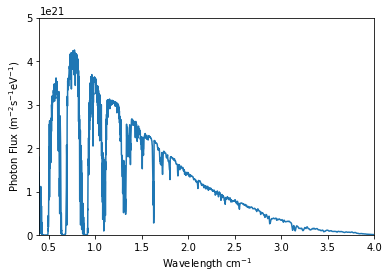

In [1]:
# Example of converting the AM1.5G spectrum to photon flux.

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import constants

h = constants.physical_constants['Planck constant in eV s'][0]
c = constants.physical_constants['speed of light in vacuum'][0]

spectrum = np.loadtxt('AM15G.csv', unpack=True, delimiter=',')

# convert to photon flux -- change units from Watts/(meter**2 nm) to #/(s meter**2 nm)
spectrum[1, :] *= spectrum[0, :] * 1e-9 / (constants.c * constants.h)

# convert photon flux and energies from nm to eV
spectrum[1, :] = (spectrum[1, :] * spectrum[0, :]**2 * 1e-9) / (h * c)
spectrum[0, :] = (h * c) / (spectrum[0, :]  * 1e-9)

plt.plot(spectrum[0,:], spectrum[1,:])
plt.gca().set(xlabel=r'Wavelength cm$^{-1}$', ylabel=r'Photon Flux (m$^{-2}$s$^{-1}$eV$^{-1}$)')
plt.xlim((0.4, 4))
plt.ylim((0, 0.5e22))
plt.show()

In [2]:
# This is a copy of the alpha2conc.py file.

import numpy as np
from scipy import interpolate, constants

h = constants.physical_constants['Planck constant in eV s'][0]
c = constants.physical_constants['speed of light in vacuum'][0]


def alpha2conc(energies, absorption, thickness, tau, energy_limits=None,
               de=0.001, dt=1e-7):
    """Calculate the carrier concentration of a material based on its absorption

    Args:
        energies (np.array): Photon energies in eV.
        absorption (np.array): Optical absorption in cm^-1.
        thickness (float): Thickness of material in cm.
        tau (float): Carrier lifetime of excited carriers in s.
        energy_limits (tuple): Integration limits for the photon energy
            as (min, max), in eV. Default is None (all energies).
        de (float): Energy integration step size in eV. Default 0.05 eV.
        dt (float): Thickness integraton step size in cm. Default 2 nm.

    Returns:
        Carrier concentration in cm^-3.
    """
    am_eners, am_spec = np.loadtxt('AM15G.csv', unpack=True, delimiter=',')

    # convert to photon flux -- from Watts/(meter**2 nm) to #/(s meter**2 nm)
    flux = am_spec * am_eners * 1e-9 / (constants.c * constants.h)

    # convert photon flux and energies from nm to eV
    flux = (flux * am_eners**2 * 1e-9) / (h * c)
    am_eners = (h * c) / (am_eners * 1e-9)

    # convert flux from m^-2 s^-1 eV^-1 to cm^-2 s^-1 eV^-1 and interpolate
    flux = interpolate.interp1d(am_eners, flux * 1e-4)

    # interpolate absorption
    alpha = interpolate.interp1d(energies, absorption)

    # widths and wavelengths over which to integrate
    widths = np.arange(0, thickness, dt)

    if not energy_limits:
        energy_limits = [max([min(energies), min(am_eners)]),
                         min([max(energies), max(am_eners)])]
    int_eners = np.arange(energy_limits[0], energy_limits[1], de)

    gen_total = 0
    for w in widths:
        exps = np.exp(-alpha(int_eners) * w)
        gen_total += np.sum(alpha(int_eners) * flux(int_eners) * exps) * de
    gen_total = gen_total * dt

    return(gen_total * tau / thickness)

In [3]:
# Example of how to use the function.

import os

bsi = np.loadtxt(os.path.join('example', 'bsi_abs.dat'), unpack=True)
bsei = np.loadtxt(os.path.join('example', 'bsei_abs.dat'), unpack=True)

print('BiSI conc = {:.3e} cm^-3'.format(alpha2conc(bsi[0,:], bsi[1,:], 2e-5, 1e-7)))
print('BiSeI conc = {:.3e} cm^-3'.format(alpha2conc(bsei[0,:], bsei[1,:], 2e-5, 1e-7)))

%timeit alpha2conc(bsi[0,:], bsi[1,:], 2e-5, 1e-7)

BiSI conc = 4.711e+14 cm^-3
BiSeI conc = 6.279e+14 cm^-3
50 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
